## Problem Description

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

## Importing the required libraries

for imblearn library, if it's not installed in the kernel, it will be installed in conda.

In [1]:
from __future__ import division
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTEENN
    from imblearn.combine import SMOTETomek
    from imblearn.ensemble import EasyEnsemble
except:
    !conda install --yes -c glemaitre imbalanced-learn
    from imblearn.combine import SMOTETomek

from sklearn.svm import SVC
from sklearn.datasets.covtype import fetch_covtype

from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%pylab inline
plt.rcParams['figure.figsize'] = (12, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\pushon\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data as Pandas DataFrame

At first try to download the dataset from the repo and load it as Pandas DataFrame. If failed, then load the dataset from local directory.

In [2]:
try:
    import urllib2, cStringIO, zipfile

    URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'

    remotezip = urllib2.urlopen(URL)
    zipinmemory = cStringIO.StringIO(remotezip.read())
    zip = zipfile.ZipFile(zipinmemory)
    for filename in zip.namelist():
        if filename == 'bank-additional/bank-additional-full.csv':
            bank_csv = zip.open(filename)
            break
    bank = pd.read_csv(bank_csv, sep=';')
    print('Loaded from the UCI repo.')
except:
    csv_file_path = "bank_data_final.csv"
    bank = pd.read_csv(csv_file_path, low_memory=True)
    print('Loaded from local directory.')

Loaded from the UCI repo.


In [3]:
#See if the dataset loaded successfully.
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data cleaning, integration, selection & transformation

Variable Identification: Here, I wrote a function for identifying the variables in a DataFrame

In [4]:
def variable_identify(df):
    df_variable_identification = pd.DataFrame(columns=['var_name','var_type', 'data_type', 'var_category'], index=range(len(bank.columns)))
    loc = 0
    for var in bank.columns:
        df_variable_identification.set_value(loc, 'var_name', var)
        if var == 'y':
            df_variable_identification.set_value(loc, 'var_type', 'target')
        else:
            df_variable_identification.set_value(loc, 'var_type', 'input')

        if (bank[var].dtype == ('object')):
            df_variable_identification.set_value(loc, 'data_type', 'string')
        elif (bank[var].dtype == ('float')):
            df_variable_identification.set_value(loc, 'data_type', 'float')
        elif (bank[var].dtype == ('bool')):
            df_variable_identification.set_value(loc, 'data_type', 'boolean')
        elif (bank[var].dtype in ('int', 'int64')):
            df_variable_identification.set_value(loc, 'data_type', 'integer')

        if (bank[var].dtype == ('object')):
            df_variable_identification.set_value(loc, 'var_category', 'cardinal')
        else:
            df_variable_identification.set_value(loc, 'var_category', 'continuous')

        loc += 1

    return df_variable_identification

df_variable_identification = variable_identify(bank)
print("The variables are shown in the table below:")
df_variable_identification

The variables are shown in the table below:


,var_name,var_type,data_type,var_category
0,age,input,integer,continuous
1,job,input,string,cardinal
2,marital,input,string,cardinal
3,education,input,string,cardinal
4,default,input,string,cardinal
5,housing,input,string,cardinal
6,loan,input,string,cardinal
7,contact,input,string,cardinal
8,month,input,string,cardinal
9,day_of_week,input,string,cardinal


Making separate lists for Continuous and Cardinal variables

In [5]:
continuous_vars = list(df_variable_identification[df_variable_identification.var_category == 'continuous'].var_name)
cardinal_vars = list(df_variable_identification[df_variable_identification.var_category == 'cardinal'].var_name)
print('Continuous variables are: %s\n' % (continuous_vars))
print('Cardinal variables are: %s\n' % (cardinal_vars)) 

Continuous variables are: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Cardinal variables are: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']



## Univariate Analysis:

At first, let's see if there is any missing values.

In [6]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing value. So missing value imputation is not required.

Now check if there are duplicate rows. 

In [7]:
##Remove duplicates (optional)
bank[['age', 'job','housing', 'month', 'nr.employed','duration']][(bank.duplicated() == True) & (bank.duration > 0)]

,age,job,housing,month,nr.employed,duration
1266,39,blue-collar,no,may,5191.0,124
12261,36,retired,no,jul,5228.1,88
14234,27,technician,no,jul,5228.1,331
16956,47,technician,yes,jul,5228.1,43
18465,32,technician,yes,jul,5228.1,128
20216,55,services,no,aug,5228.1,33
20534,41,technician,yes,aug,5228.1,127
25217,39,admin.,no,nov,5195.8,123
28477,24,services,yes,apr,5099.1,114
32516,35,admin.,yes,may,5099.1,348


In [8]:
bank.drop_duplicates(inplace=True)
len(bank)

41176

12 Duplicated rows are deleted. Now let's look at each variable individually. At first get basic insight through describe() method. 

In [9]:
print('Descriptive stat of Continuous variables:')
bank[continuous_vars].describe()

Descriptive stat of Continuous variables:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


From above table, it is evident that the max value of 'duration', 'campaign', 'pdays' needs to be treated appropriately.
Moreover, 'nr.employed' should be integer.
Note: Although the max value of 'age', 98 might seem like an outlier considering (> mean + ( 1.5 *IQR)), but it's a reasonable value for a client's age.

Now let's analysis the variables using boxplot, distplot, and violinplot

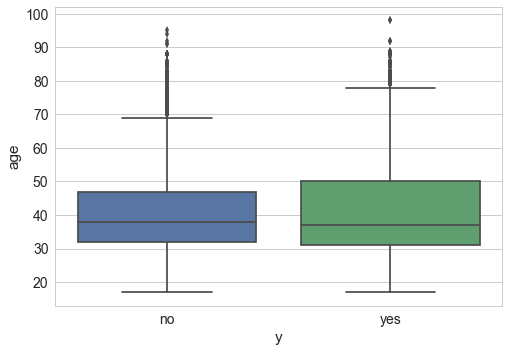

In [10]:
# Continious: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
#var_fig = bank_copy.age
# fig, axs = plt.subplots(ncols=1, nrows=3)
# sns.distplot(var_fig, ax=axs[0])
# sns.boxplot(var_fig, color = "green", orient = "v", ax=axs[1])
# sns.violinplot(var_fig, color = 'cyan', clip=(0,6000), ax=axs[2])
sns.set(style='whitegrid', context='notebook', font_scale=1.4)
sns.boxplot(x='y', y='age', orient = "v", data=bank)

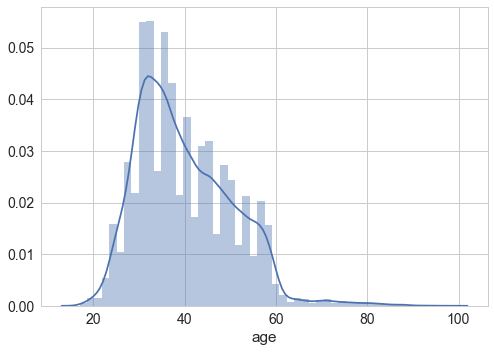

In [11]:
dist = sns.distplot(bank['age'])
#bx.set_yscale('log')

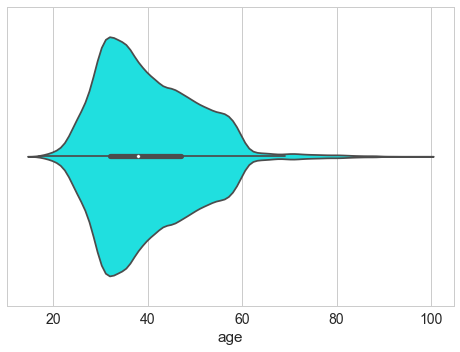

In [13]:
sns.violinplot(bank['age'], color = 'cyan')

After analysing the continuous variables, it seems like:
<br>-duration, campaign have outliers (max val)
<br>-pdays 999 vals should be treated as NaN [this column can be removed since more than 96% values are unknown]
<br>-pdays can be transformed into a new  cardinal variable 'is_prev_contacted';
<br>    where is_prev_contacted=0 if pdays==999 else is_prev_contacted=1
<br>-'previous' maybe transformed into cardinal(1 or 0), since 87% values are 0 and for all 'previous'=0, 'y'=no
<br>-nr.employed should be integer value

In [14]:
#'duration': impute outliers (> mean + 2 * IQR) with mean + 2 * IQR
duration_thresh = bank.duration.mean() + 2.0 *(bank.duration.quantile(0.75) - bank.duration.quantile(0.25))
bank['duration'][bank['duration']> duration_thresh] = duration_thresh

C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
#'campaign': impute outliers (> mean + 2 * IQR) with mean + 2 * IQR
campaign_thresh = bank.campaign.mean() + 2.0 *(bank.campaign.quantile(0.75) - bank.campaign.quantile(0.25))
bank['campaign'][bank['campaign']> campaign_thresh] = campaign_thresh

C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
# 'is_prev_contacted' variable created from 'pdays'
bank['is_prev_contacted'] = bank['pdays'][:]
bank['is_prev_contacted'][bank['pdays'] == 999] = 0
bank['is_prev_contacted'][bank['pdays'] != 999] = 1
bank.drop(['pdays'], axis=1, inplace=True)

C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# (Optional) 'previous_cardinal' variable created from 'previous'
bank['previous_cardinal'] = bank['previous'][:]
bank['previous_cardinal'][bank['previous'] > 0] = 1
bank['previous_cardinal'][bank['previous'] == 0] = 0
bank.drop(['previous'], axis=1, inplace=True)
bank.rename(columns ={'previous_cardinal': 'previous'}, inplace =True)

C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\pushon\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# Convert nr.employed into integer value
bank['nr.employed'] = bank['nr.employed'].round().astype(int)

Continuous vars are done....

Now let's explore the cardinal variables:

In [19]:
bank[cardinal_vars].describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


   The target variable has two classes. The class with 'no' values are very dominant (36537 / 41176 = 89%). Therefore, the dataset should transformed into a balanced one before applying ML classification algorithms.
   Note: There are 'unknown' values in ['job', 'marital', 'default', 'housing', 'loan']. I am keeping them without changing.

## Bivariate Analysis:

#For continuous variables, before analysing the correlation let's change the target variable into numeric one.

In [20]:
bank_target_cardinal = bank['y']
bank_target_numeric = bank_target_cardinal.map({'yes':1, 'no':0}) #it will also needed before training the models
bank['y_numeric'] = bank_target_numeric

Let's look at the scatter plots for potential correlation between 'y_numeric' and other variables.

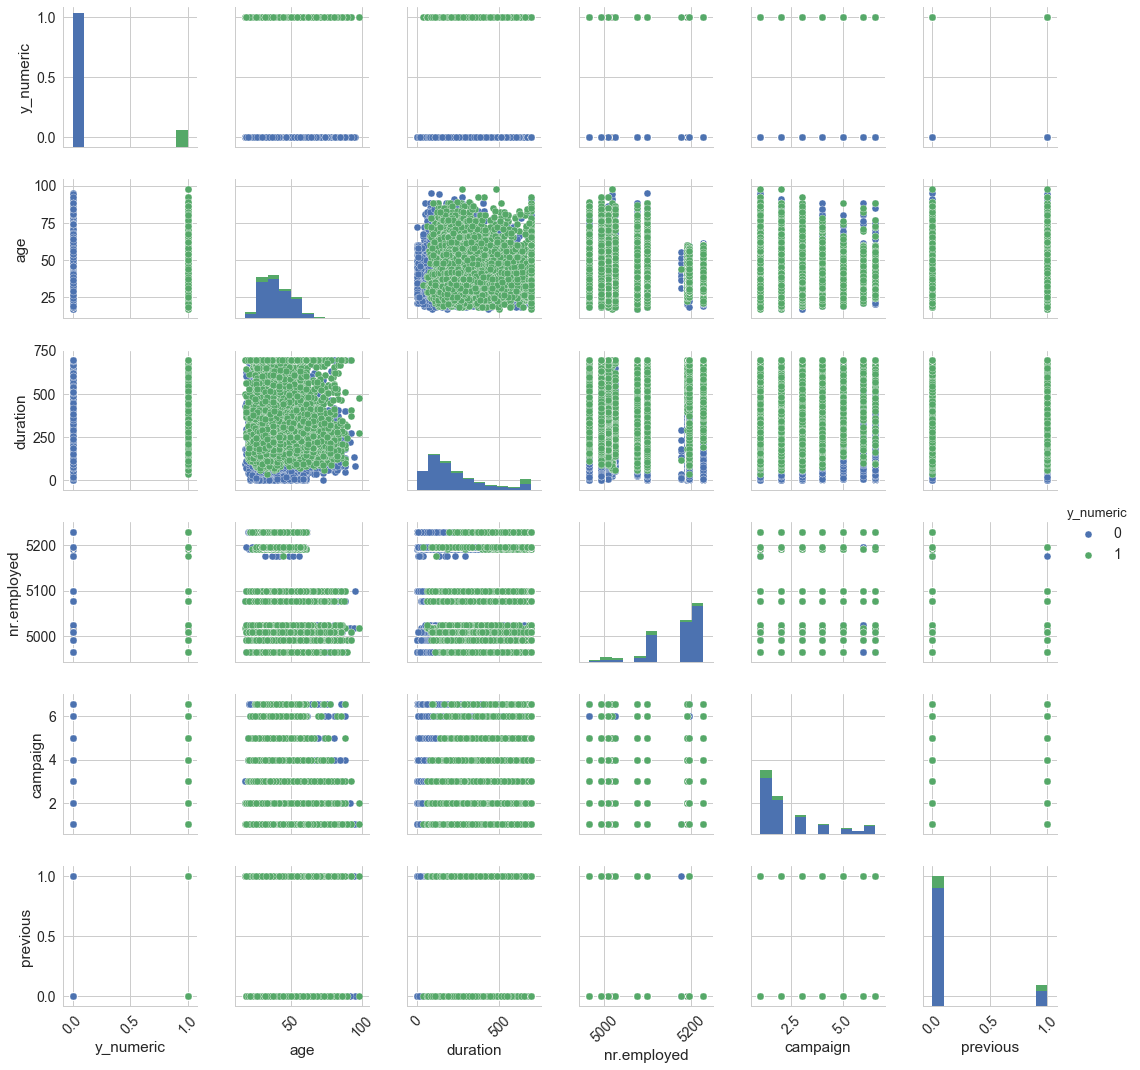

In [21]:
sns.set(style='whitegrid', context='notebook', font_scale=1.4)
g = sns.pairplot(bank[['y_numeric', 'age','duration', 'nr.employed', 'campaign','previous']], hue="y_numeric", diag_kind="hist")  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

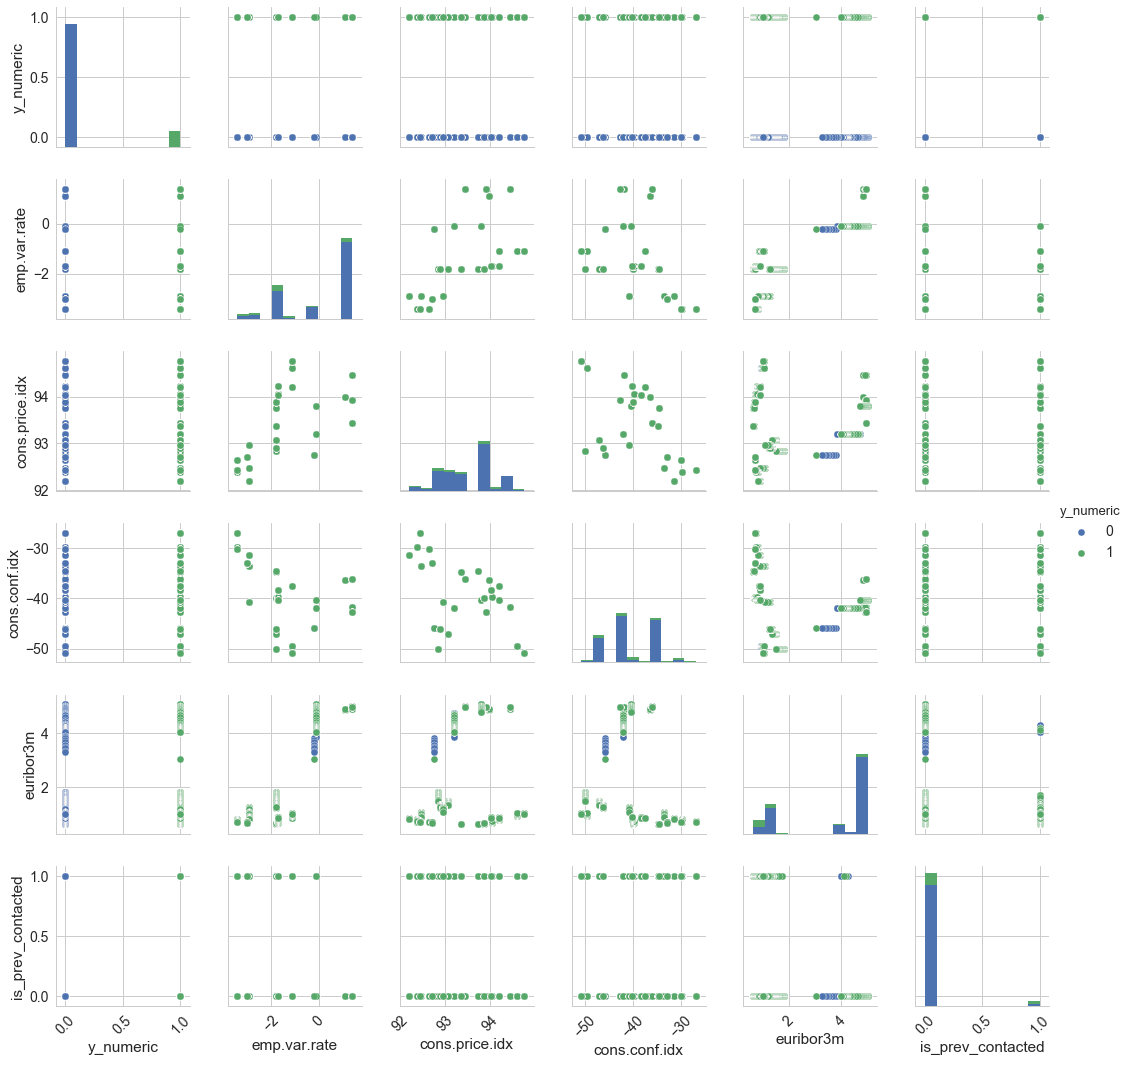

In [22]:
sns.set(style='whitegrid', context='notebook', font_scale=1.4)
g_2 = sns.pairplot(bank[['y_numeric', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'is_prev_contacted']], hue="y_numeric", diag_kind="hist")  
for ax in g_2.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

Not much correlation between 'y_numeric' and other variables can seen from these scatter plots. So new features can't be created using these plots. Also most of the variables are not normally distributed.

In [23]:
#updating continuous_vars list so that correlation between each of them can be seen easily:
continuous_vars.append('y_numeric')
continuous_vars.append('is_prev_contacted')

continuous_vars.remove('pdays')

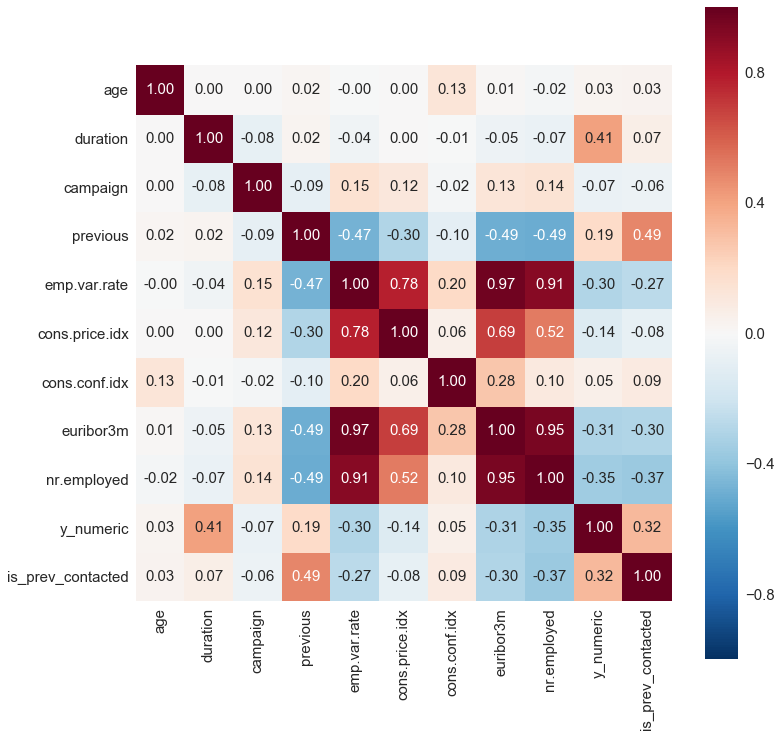

In [24]:
# Plot correlation matrix
plt.figure(figsize=(12, 12))
sns.set(style='whitegrid', context='notebook', font_scale=1.5)
m = sns.heatmap(bank[continuous_vars].corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=continuous_vars, xticklabels=continuous_vars)
plt.show()

y_numeric is moderately positively correlated with 'duration' (r = 0.41) and 'is_prev_contacted (r = 0.32)'. This seems reasonable.

In [25]:
# chi2_contingency for determining relationship between y and other cardinal variables

list_chi2_p_val = []

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

for cardinal_var in cardinal_vars:
    if cardinal_var == 'y':
        continue
    _, p, __, ___ = chisq_of_df_cols(bank, 'y', cardinal_var)
    list_chi2_p_val.append((cardinal_var, p))
    
print('List of p-vals = %s' %(list_chi2_p_val))

List of p-vals = [('job', 3.2684116066165443e-199), ('marital', 1.7784225004611415e-26), ('education', 3.7467683775347438e-38), ('default', 5.2175408937279634e-89), ('housing', 0.056637927494525425), ('loan', 0.57715320811762272), ('contact', 1.7187406241263769e-189), ('month', 0.0), ('day_of_week', 3.0857549656317429e-05), ('poutcome', 0.0)]


Using chi2_contingency, it can be said that target variable 'y' depends significantly on each of the cardinal variables (most p values are less than 0.01). Only 'loan' has p value higher than 0.5. So 'loan' could be deleted.

## Final preprocessing:

In [26]:
bank_target = bank_target_numeric
bank.drop(['y', 'y_numeric'], axis=1, inplace=True)

Before training the data into ML algorithms, we need to make sure that none of the features have string value. The following function will transform the cardinal variable with string values into numeric variable having only 1 or 0 as values.

In [27]:
##Apply one-hot encoding
def one_hot_dataframe(data, cols, replace=False):
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform(data[cols].apply(mkdict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData)

bank, bank_old = one_hot_dataframe(bank, ['job', 'marital', 'education','default', 'housing', 'loan','contact','month','day_of_week', 'poutcome'], replace=True)

In [28]:
# Check if the tansform went well.
bank[:3]

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,is_prev_contacted,previous,...,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep,poutcome=failure,poutcome=nonexistent,poutcome=success
0,56,261.0,1.0,1.1,93.994,-36.4,4.857,5191,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149.0,1.0,1.1,93.994,-36.4,4.857,5191,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226.0,1.0,1.1,93.994,-36.4,4.857,5191,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train and test data split. Creating test data with 20% of total data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(bank, bank_target, test_size=0.20, random_state=33)

### Building Classifiers

In [30]:
##Use a RandomForestClassifier initially to see the simple performance
model_rf = RandomForestClassifier(n_estimators=200, max_features=8)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [31]:
y_pred_rf_train = model_rf.predict(X_train)
y_pred_rf = model_rf.predict(X_test)

In [34]:
#See different evaluation metrics
def view_scores(y_train, y_test, y_pred_model_train, y_pred_rf): 
    model_train_recall = recall_score(y_train, y_pred_model_train)
    model_test_recall = recall_score(y_test, y_pred_rf)
    model_train_prec = precision_score(y_train, y_pred_model_train)
    model_test_prec = precision_score(y_test, y_pred_rf)
    model_train_f1 = f1_score(y_train, y_pred_model_train)
    model_test_f1 = f1_score(y_test, y_pred_rf)
    model_train = accuracy_score(y_train, y_pred_model_train)
    model_test = accuracy_score(y_test, y_pred_rf)
    model_train = roc_auc_score(y_train, y_pred_model_train)
    model_test = roc_auc_score(y_test, y_pred_rf)

    model_train_confusion_matrix = confusion_matrix(y_train, y_pred_model_train)
    model_train_tp = (model_train_confusion_matrix[0][0])/np.sum(model_train_confusion_matrix[0])
    model_train_fp = (model_train_confusion_matrix[1][1])/np.sum(model_train_confusion_matrix[1])

    model_test_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
    

    print('train/test recall %.4f/%.4f' % (model_train_recall, model_test_recall))
    print('train/test precision %.4f/%.4f' % (model_train_prec, model_test_prec))
    print('train/test F1 %.4f/%.4f' % (model_train_f1, model_test_f1))
    print('train/test accuracies %.4f/%.4f' % (model_train, model_test))
    print('train/test ROC Area %.4f/%.4f' % (model_train, model_test))
    print('train/test accuracies %.4f/%.4f\n' % (model_train, model_test))
    
    print('View the confusion matrix below:')
    
    #plot confusion_matrix
    sns.reset_orig() # discard seaborn sttings for plots
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(model_test_confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(model_test_confusion_matrix.shape[0]):
        for j in range(model_test_confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=model_test_confusion_matrix[i, j], va='center', ha='center')
            
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix')
    plt.show()


train/test recall 0.9995/0.4664
train/test precision 0.9997/0.6361
train/test F1 0.9996/0.5382
train/test accuracies 0.9997/0.7164
train/test ROC Area 0.9997/0.7164
train/test accuracies 0.9997/0.7164

View the confusion matrix below:


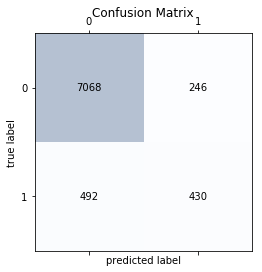

In [35]:
view_scores(y_train, y_test, y_pred_rf_train, y_pred_rf)

### The recall, f1_score are not good enough. It failed to predict the positive class more than 50% cases. The train data is moderately imbalanced. Let's see the ratio.

In [36]:
class_ratio = len(y_train[(y_train == 0)]) / len(y_train[(y_train == 1)])
print('Ratio is: 1:%.3f' % (class_ratio))

Ratio is: 1:7.862


Now let's create a balanced tarining dataset using diffrent techniques. Here, the combination of SMOT-SVM (Synthetic Minority Over-sampling Technique) and TOMEK link gave the best result.

In [37]:
sm = SMOTETomek(kind_smote='svm')
X_res, y_res = sm.fit_sample(X_train, y_train)

In [38]:
print('Number of positive-class data after applying SMOTETomek: %d' % (len(y_res[(y_res == 1)])))
print('Number of negative-class data after applying SMOTETomek: %d' % (len(y_res[(y_res == 0)])))

class_ratio_sm = len(y_res[(y_res == 0)]) / len(y_res[(y_res == 1)])
print('Ratio is after applying SMOTETomek: 1:%.3f' % (class_ratio_sm))

Number of positive-class data after applying SMOTETomek: 29222
Number of negative-class data after applying SMOTETomek: 29046
Ratio is after applying SMOTETomek: 1:0.994


Now let's visualize the new training data

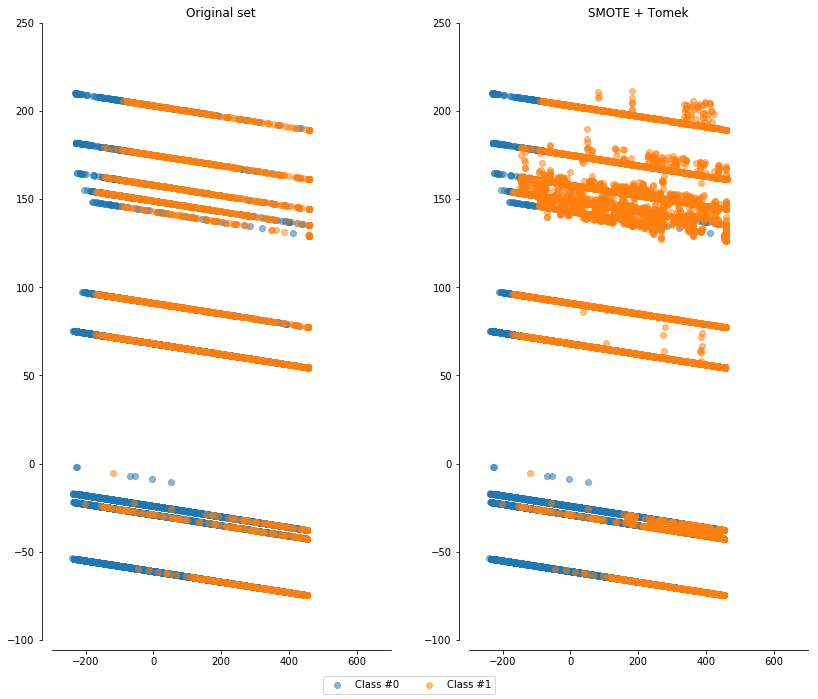

In [39]:
plt.rcParams['figure.figsize'] = (12, 10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)
X_res_vis = pca.transform(X_res)

f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y_train == 0, 0], X_vis[y_train == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y_train == 1, 0], X_vis[y_train == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_res == 0, 0], X_res_vis[y_res == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_res == 1, 0], X_res_vis[y_res == 1, 1],
            label="Class #1", alpha=0.5)
ax2.set_title('SMOTE + Tomek')

# make plot
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-300, 700])
    ax.set_ylim([-100, 250])

plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

It is clear that, after applying SMOTETomek new similar rows created.

Now Let's create a RandomForestClassifier with this balanced training data

In [40]:
model_rf_sm = RandomForestClassifier(n_estimators=200, max_features=8)
model_rf_sm.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
y_pred_rf_sm_train = model_rf_sm.predict(X_res)
y_pred_rf_sm = model_rf_sm.predict(X_test)

train/test recall 1.0000/0.5564
train/test precision 0.9999/0.6181
train/test F1 0.9999/0.5856
train/test accuracies 0.9999/0.7565
train/test ROC Area 0.9999/0.7565
train/test accuracies 0.9999/0.7565

View the confusion matrix below:


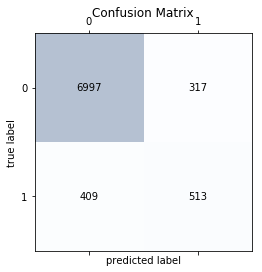

In [42]:
view_scores(y_res, y_test, y_pred_rf_sm_train, y_pred_rf_sm)

After training the balanced dataset, it's clear that the model's performance improved significantly. Here y='yes' is positive class. so the recall is more important than precision. We will try to improve recall, F1-score, and ROC Area primarily. 

In [43]:
##Feature importance table
feat_labels = X_train.columns
importances = model_rf_sm.feature_importances_
indices = np.argsort(importances)[::-1]
print "Printing Feature Importances of RandomForest"
for f in range(X_res.shape[1]):
    print "%2d) %-*s %f" % (f + 1, 40, feat_labels[f], importances[indices[f]])


Printing Feature Importances of RandomForest
 1) age                                      0.329379
 2) duration                                 0.075502
 3) campaign                                 0.069379
 4) emp.var.rate                             0.045359
 5) cons.price.idx                           0.030357
 6) cons.conf.idx                            0.027340
 7) euribor3m                                0.024514
 8) nr.employed                              0.023995
 9) is_prev_contacted                        0.018506
10) previous                                 0.018251
11) contact=cellular                         0.018200
12) contact=telephone                        0.018061
13) day_of_week=fri                          0.016015
14) day_of_week=mon                          0.015992
15) day_of_week=thu                          0.015804
16) day_of_week=tue                          0.015763
17) day_of_week=wed                          0.013732
18) default=no                       

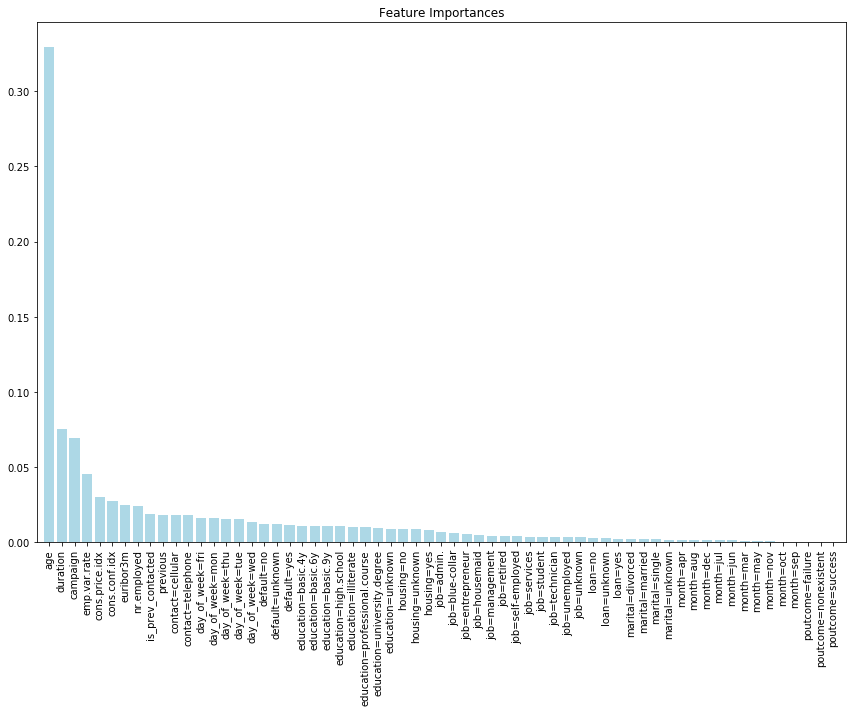

In [45]:
#Plot 'Feature Importances'
plt.rcParams['figure.figsize'] = (12, 10)

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],
        color='lightblue', align='center')

plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## Build Ensemble Classifier!

Now let's use ensemble method through VotingClassifier by combining diffrent classifiers. One individual classifier may not learn from the data enough and more likely to underperform with unseen data. However, combination of two or more classifiers would make a robust model with improved performance. These classifiers are selected after evaluating many classifiers. The correlation between the classifiers were also considered. The following code was used:
>>np.corrcoef([y_pred_model_1, y_pred_model_2])

Highly correalted classifiers was not selected. Here, each classifier was hyper-tuned using grid search.
<br>I also used f1_score as the evalution metric since accuracy would not be a good metrics for this skewed dataset.
<br>Note: I wanted to use SVC() in this ensemble but it is very time consuming. SVC() performed well with this dataset.

In [46]:
#Ensemle using LogisticRegression, RandomForestClassifier, MLPClassifier, and GradientBoostingClassifier

def ensemble_classifier(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    

    clf1 = LogisticRegression(random_state=1)
#     clf2 = KNeighborsClassifier(n_neighbors=5)
    clf2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.07, max_features=8, random_state=0)
    clf3 = RandomForestClassifier(random_state=1)
    clf4 = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(24, 2), max_iter=1000, random_state=1)

    eclf = VotingClassifier(estimators=[('lr', clf1), 
                                        ('gnb', clf2), 
                                        ('rf', clf3), 
                                        ('nn', clf4)], voting='soft', weights=[1,1,1])

    params = {'lr__max_iter': [200], 'rf__n_estimators': [100], 'rf__max_features': [8], 'weights':[[3,2,3,4]]}

    grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5, scoring=make_scorer(f1_score))
    ensemble_grid = grid.fit(X_train_std, y_train)
        
    return ensemble_grid, X_train_std, X_test_std

In [47]:
model_ens, X_train_std, X_test_std = ensemble_classifier(X_res, X_test, y_res, y_test)

In [48]:
y_pred_ens_train = model_ens.predict(X_train_std)
y_pred_ens = model_ens.predict(X_test_std)

train/test recall 0.9846/0.8243
train/test precision 0.9220/0.5040
train/test F1 0.9523/0.6255
train/test accuracies 0.9504/0.8610
train/test ROC Area 0.9504/0.8610
train/test accuracies 0.9504/0.8610

View the confusion matrix below:


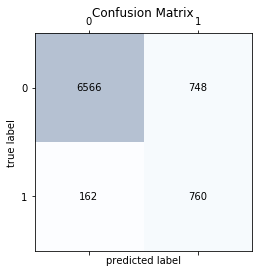

In [49]:
view_scores(y_res, y_test, y_pred_ens_train, y_pred_ens)

Let's see how this classifier is performing by looking at the ROC curve.

In [52]:
def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    plt.rcParams['figure.figsize'] = (12, 10)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

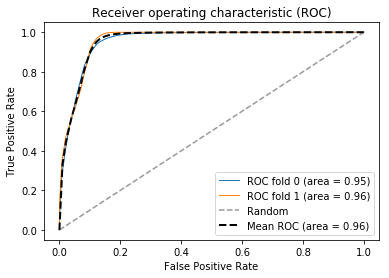

In [51]:
plot_ROC_curve(model_ens, X_train_std, y_res, pos_label=1, n_folds=2)

From above ROC Area curve, it can be said that the classifier did really well on the training data. The area under the ROC curve is 96% which is really good.

### In this problem, the positive class (y='yes') is more important. In this imbalance dataset the recall and F1-score are much more important than the accuracy of the model. Therefore, the recall should be high. Now this is a business decision to set the required recall and precision values for maximizing profit. The important thing is to achieve the desired recall/precision value by tweaking the model. Here I am going to change the threshold for decision function. 0.5 is the default threshold probability for two-class classification. By changing this threshold, the desired recall/precision can be achieved.

In [53]:
y_proba_ens = model_ens.predict_proba(X_test_std)

train/test recall 0.9846/0.8720
train/test precision 0.9220/0.4766
train/test F1 0.9523/0.6163
train/test accuracies 0.9504/0.8756
train/test ROC Area 0.9504/0.8756
train/test accuracies 0.9504/0.8756

View the confusion matrix below:


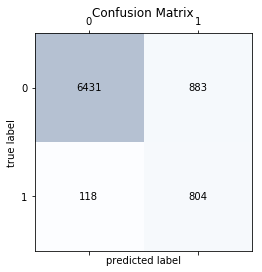

In [56]:
y_pred_ens_final = np.where(y_proba_ens[:, 1] > 0.47, 1, 0)
view_scores(y_res, y_test, y_pred_ens_train, y_pred_ens_final)

From the above figure, it is clear that, the ensemble classifier predicted 804 subcriptions(y='yes') rightly and missed 118 subcriptions. On the other hand, it wrongfully predicted 883 non-subscriptions as subscriptions and rightly predicted 6431 non-subcriptions.
<br> Seems like a good classifier!

Using the above technique,we can the desired/optimum recall/precision.